In [1]:
%matplotlib inline

# This notebook is a quick and dirty comparison of HISAT2 based mappings (calculated from the `.wig` files as in other notebooks) versus comparable RNA estimates from Kallisto as sort of a "check" on both programs and the methods.

Not expecting it to be perfect but the should correspond closely

In [2]:
import pandas as pd
from Bio import SeqIO
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

# This is just all copy/pasted code from other notebooks to get RPKM for genes using the `.wig` files

In [3]:
mapping_offset = -9
utr_length_to_include = 50

genome_file = '../Data/Genome_files/U00096.3.fasta'
genome_seq = list(SeqIO.parse(genome_file, 'fasta'))[0]
organism = 'Escherichia'

utr_sequence_dict = {}
full_sequence_dict = {}
strand_dict = {}
location_dict = {}
genbank_seq = list(SeqIO.parse('../Data/Genome_files/U00096.3.gb', 'genbank'))[0]
for feature in genbank_seq.features:
    if feature.type != 'CDS':
        continue
    elif 'pseudo' in feature.qualifiers:
        continue
    name = feature.qualifiers['locus_tag'][0] + '_' + feature.qualifiers['gene'][0]
    start = feature.location.start
    end = feature.location.end
    ###Sequence for positive strand genes
    if feature.strand == 1:
        seq = str(genbank_seq.seq[start-utr_length_to_include:end+utr_length_to_include])
    ###Sequence for negative strand genes needs to be reverse complemented
    elif feature.strand == -1:
        seq = str(genbank_seq.seq[start-utr_length_to_include:end+utr_length_to_include].reverse_complement())
    
    full_sequence_dict[name] = seq
    
    ###Separately just grab the 5'UTR as its own dictionary because it may be helpful
    utr_seq = seq[:utr_length_to_include]
    utr_sequence_dict[name] = utr_seq
    
    ###Store strand and locations
    strand_dict[name] = feature.strand
    location_dict[name] = (start, end)

print(len(utr_sequence_dict.keys()))
print(len(full_sequence_dict.keys()))
print(len(strand_dict.keys()))
print(len(location_dict.keys()))


sample_files = [('WTrep1_rna', '../Data/WIG_files/WTrep1.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep1.rna_cigar_fulladjust_r.wig'),\
               ('WTrep2_rna', '../Data/WIG_files/WTrep2.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/WTrep2.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep1_rna', '../Data/WIG_files/RIBOTrep1.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep1.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep2_rna', '../Data/WIG_files/RIBOTrep2.rna_cigar_fulladjust_f.wig', '../Data/WIG_files/RIBOTrep2.rna_cigar_fulladjust_r.wig')]

sample_names = [i[0] for i in sample_files]


feature_dict_meta = {}
for sample_file in sample_files[:]:
    sample_name, fwd, rev = sample_file
    print('##### {}'.format(sample_name))
    feature_dict_meta[sample_name] = {}
    
    ################################
    ###Essentially get the fwd and rev genome coverage
    fwd_dicty = {}
    rev_dicty = {}
    with open(fwd) as infile:
        for line in enumerate(infile):
            if line[0] > 0:###Ignore the first line of the file
                split_line = line[1].split('\t')
                fwd_dicty[int(split_line[0])+mapping_offset] = float(split_line[1])#Note: mapping offset addition
    print('Done with fwd')
    with open(rev) as infile:
        for line in enumerate(infile):
            if line[0] > 0:###Ignore the first line of the file
                split_line = line[1].split('\t')
                rev_dicty[int(split_line[0])-mapping_offset] = float(split_line[1])#Note: mapping offset subtraction
    print('Done with rev')
    for gene_name in full_sequence_dict.keys():        
        ####Dealing with positive strand genes first
        if strand_dict[gene_name] == 1:
            ###Get all positions that I care about
            pos = (location_dict[gene_name][0]-utr_length_to_include, location_dict[gene_name][1]+utr_length_to_include)
            if pos[1] < pos[0]:
                print('found a bug')
                continue
            sequencing = []
            ###Append read values and if there are none, append zero
            for i in range(pos[0], pos[1]+1):
                try:
                    sequencing.append(fwd_dicty[i])
                except KeyError:
                    sequencing.append(0)
            feature_dict_meta[sample_name][gene_name] = sequencing
        ####And repeat for negative strand genes
        elif strand_dict[gene_name] == -1:
            pos = (location_dict[gene_name][0]-utr_length_to_include, location_dict[gene_name][1]+utr_length_to_include)
            if pos[1] < pos[0]:
                print('found a bug')
                continue
            sequencing = []
            for i in range(pos[0], pos[1]+1):
                try:
                    sequencing.append(rev_dicty[i])
                except KeyError:
                    sequencing.append(0)
            feature_dict_meta[sample_name][gene_name] = sequencing[::-1]###Note the CRUCIAL reverse here
            
total_read_dict = {}
for i in sample_names:
    all_features = []
    for j in feature_dict_meta[i].values():
        all_features.extend(j[utr_length_to_include:-1*utr_length_to_include])
    print(i, np.sum(all_features))
    total_read_dict[i] = np.sum(all_features)

4240
4240
4240
4240
##### WTrep1_rna
Done with fwd
Done with rev
##### WTrep2_rna
Done with fwd
Done with rev
##### RIBOTrep1_rna
Done with fwd
Done with rev
##### RIBOTrep2_rna
Done with fwd
Done with rev
WTrep1_rna 4128696.0
WTrep2_rna 3909237.0
RIBOTrep1_rna 4243296.0
RIBOTrep2_rna 3062815.0


# Compiling `.wig` data into RPKM for the genes

In [4]:
df_master = pd.DataFrame()
for sample in sample_names:
    print(sample)
    for gene in strand_dict.keys():
        gene_len = location_dict[gene][1]-location_dict[gene][0]
        ###Only calculating averages across the CDS (ignoring UTRs)
        reads = feature_dict_meta[sample][gene][utr_length_to_include:-1*utr_length_to_include]
        ###This is the formula for making these values RPKM
        df_master.set_value(gene, sample, (np.sum(reads)*10e9)/(total_read_dict[sample]*gene_len))
        df_master.set_value(gene, sample+'_raw_counts', np.sum(reads))
df_master.head()

WTrep1_rna
WTrep2_rna
RIBOTrep1_rna
RIBOTrep2_rna


,WTrep1_rna,WTrep1_rna_raw_counts,WTrep2_rna,WTrep2_rna_raw_counts,RIBOTrep1_rna,RIBOTrep1_rna_raw_counts,RIBOTrep2_rna,RIBOTrep2_rna_raw_counts
b3597_yibH,74.558073,35.0,89.992751,40.0,70.471761,34.0,83.275408,29.0
b3433_asd,1333.894861,608.0,1380.972994,596.0,1353.370970,634.0,1283.511874,434.0
b3377_yhfT,61.247804,33.0,74.487103,38.0,79.458221,44.0,50.037859,20.0
b1609_rstB,643.653608,346.0,807.493132,411.0,662.470850,366.0,609.360816,243.0
b3120_yhaB,13.455957,3.0,4.737118,1.0,4.364183,1.0,30.231206,5.0


# Reading in Kallisto data

In [5]:
sample_ids = ['WTrep1', 'WTrep2', 'RIBOTrep1', 'RIBOTrep2']
df_kal = pd.read_csv('../Data/Kallisto_output/kallisto_rna.tsv', sep='\t', index_col=1)
df_kal.head()

,target_id,sample,est_counts,tpm,eff_len,len,condition
b0001_thrL,1,RIBOTrep1,516.371434,5311.636414,8.781648,66,RiboT
b0001_thrL,2,RIBOTrep2,471.480351,4856.056700,8.781648,66,RiboT
b0001_thrL,3,WTrep1,453.127495,4657.632225,8.781648,66,WT
b0001_thrL,4,WTrep2,462.790030,4754.580149,8.781648,66,WT
b0002_thrA,5,RIBOTrep1,2366.930085,90.975709,2350.185433,2463,RiboT


# Merging and plotting

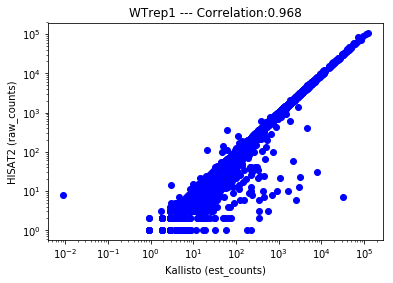

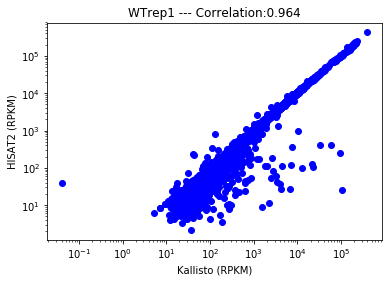

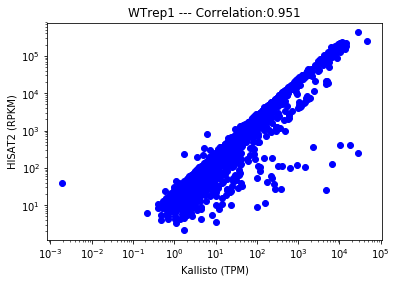

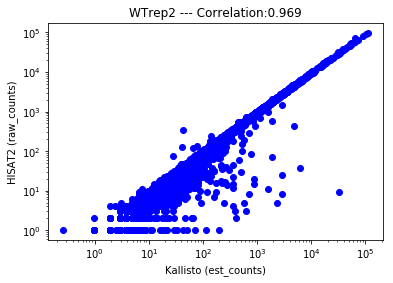

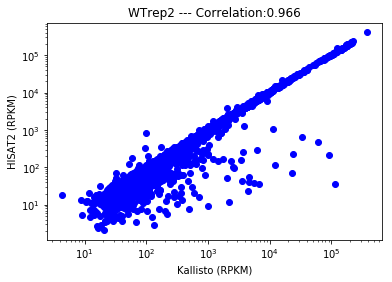

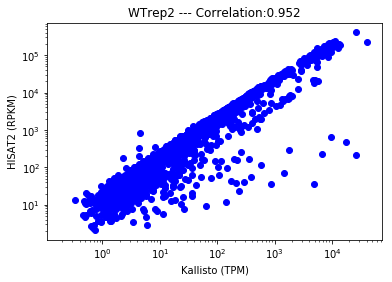

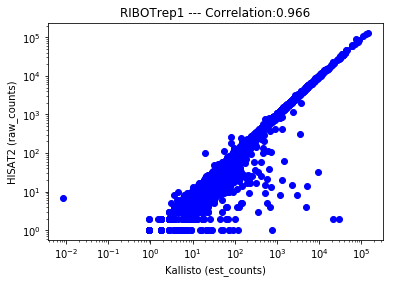

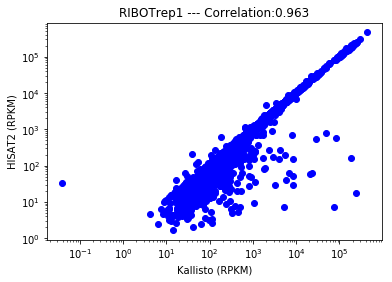

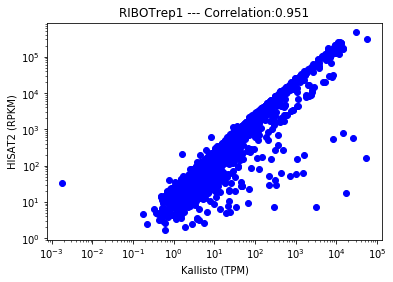

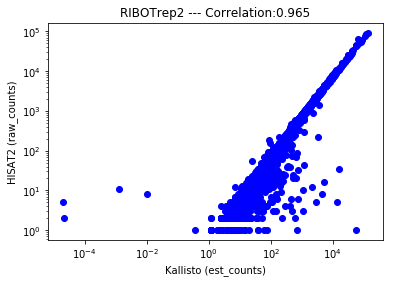

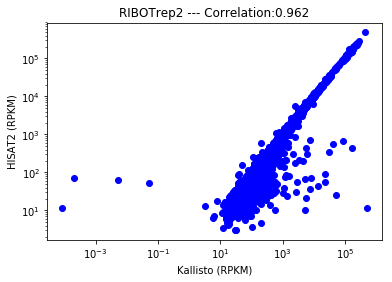

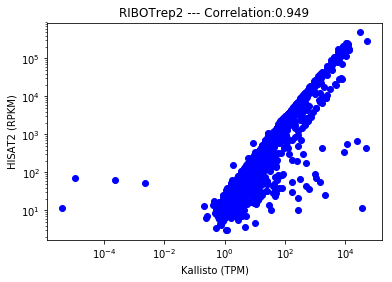

In [6]:
for sample_id in sample_ids:
    ###Merging data together
    temp_df_kal = df_kal[df_kal['sample']==sample_id]
    temp_df_kal = temp_df_kal.merge(df_master[[sample_id+'_rna', sample_id+'_rna'+'_raw_counts']], left_index=True, right_index=True)
    ###Calculating an RPKM equivalent for Kallisto
    total_counts = np.sum(temp_df_kal['est_counts'])
    temp_df_kal['RPKM_kal'] = (temp_df_kal['est_counts']*10e9)/(total_counts*temp_df_kal['len'])
    
    ###Comparing results
    a = temp_df_kal['est_counts']
    b = temp_df_kal[sample_id+'_rna'+'_raw_counts']
    fig, ax = plt.subplots()
    ax.loglog(a,b, 'bo')
    ax.set_xlabel('Kallisto (est_counts)')
    ax.set_ylabel('HISAT2 (raw_counts)')
    rho, p = stats.spearmanr(a,b)
    ax.set_title('{} --- Correlation:{:.3f}'.format(sample_id, rho))
    
    a = temp_df_kal['RPKM_kal']
    b = temp_df_kal[sample_id+'_rna']
    fig, ax = plt.subplots()
    ax.loglog(a,b, 'bo')
    ax.set_xlabel('Kallisto (RPKM)')
    ax.set_ylabel('HISAT2 (RPKM)')
    rho, p = stats.spearmanr(a,b)
    ax.set_title('{} --- Correlation:{:.3f}'.format(sample_id, rho))
    
    a = temp_df_kal['tpm']
    b = temp_df_kal[sample_id+'_rna']
    fig, ax = plt.subplots()
    ax.loglog(a,b, 'bo')
    ax.set_xlabel('Kallisto (TPM)')
    ax.set_ylabel('HISAT2 (RPKM)')
    rho, p = stats.spearmanr(a,b)
    ax.set_title('{} --- Correlation:{:.3f}'.format(sample_id, rho))

# What are the genes on the bottom right of these plots?

Kallisto is telling us that this set of ~20 genes is much more highly expressed than HISAT2 is telling us. From visual inspection/googling, these genes look mostly like insertion elements, prophages, unannotated genes, etc. 

Which is to say, they're probably nothing important to care about too much but we should take care not to draw conclusions about these genes from any of our analyses. It is entirely unclear which of the two measurements is "correct" for these genes but they are few in number and the correlations are strong overall between the methods

In [8]:
for sample_id in sample_ids:
    ###Merging data together
    temp_df_kal = df_kal[df_kal['sample']==sample_id]
    temp_df_kal = temp_df_kal.merge(df_master[[sample_id+'_rna', sample_id+'_rna'+'_raw_counts']], left_index=True, right_index=True)
    ###Calculating an RPKM equivalent for Kallisto
    total_counts = np.sum(temp_df_kal['est_counts'])
    temp_df_kal['RPKM_kal'] = (temp_df_kal['est_counts']*10e9)/(total_counts*temp_df_kal['len'])
    
    temp_df_kal['ratio'] = temp_df_kal['est_counts'] / temp_df_kal[sample_id+'_rna_raw_counts']
    
    ###List everyone where the ratio of the counts is greater than 5 subject to the constraing
    ###that there are at least 10 mapped hisat2 reads
    temp_df_kal = temp_df_kal[(temp_df_kal['ratio'] > 5) & (temp_df_kal[sample_id+'_rna_raw_counts'] > 10)]
    print('##########')
    print(temp_df_kal[[sample_id+'_rna_raw_counts', 'est_counts']])
    

##########
              WTrep1_rna_raw_counts   est_counts
b0022_insA-1                   20.0   167.676782
b0077_ilvI                     59.0  2133.199377
b0117_yacH                     13.0    66.219049
b0259_insH-1                  403.0  4664.616450
b0299_insF-1                   42.0   312.175519
b0322_yahH                     13.0  2993.101032
b0361_insD-1                   64.0   489.278831
b0484_copA                     97.0   735.806033
b0532_sfmD                     30.0  8030.478718
b0988_insB-4                   24.0   461.687450
b1147_ymfL                     23.0  3132.161036
b1433_ydcO                     11.0   117.302316
b2389_yfeO                     17.0   142.843949
b2443_yffL                     37.0   214.738917
b2586_yfiM                     24.0   373.664636
b2866_xdhA                     30.0   236.496605
b2875_yqeB                     34.0   320.689396
b2956_yggM                     22.0  1095.452274
b2981_yghO                     22.0   326.967282
b3422_rtc